In [4]:
import pandas as pd
import pandas as pd
from collections import defaultdict, Counter
import matplotlib.pyplot as plt

In [5]:
strict = pd.read_csv(
    "blast_strict.homologous_pairs.tsv",
    sep=r"\s+",
    header=None,
    engine="python"
)

medium = pd.read_csv(
    "blast_medium.homologous_pairs.tsv",
    sep=r"\s+",
    header=None,
    engine="python"
)

lenient = pd.read_csv(
    "blast_lenient.homologous_pairs.tsv",
    sep=r"\s+",
    header=None,
    engine="python"
)
strict.head()

,0,1,2
0,Al_scaffold_0001_1000,scaffold_101081.1,187
1,Al_scaffold_0001_1004,fgenesh1_pg.C_scaffold_1003897,375
2,Al_scaffold_0001_1004,fgenesh1_pg.C_scaffold_6002203,376
3,Al_scaffold_0001_1004,fgenesh1_pm.C_scaffold_6001283,334
4,Al_scaffold_0001_1004,fgenesh2_kg.2__1087__AT1G68380.1,336


In [3]:
strict.columns = medium.columns = lenient.columns = [
    "query_id",
    "subject_id",
    "value"
]
strict.head()

,query_id,subject_id,value
0,Al_scaffold_0001_1000,scaffold_101081.1,187
1,Al_scaffold_0001_1004,fgenesh1_pg.C_scaffold_1003897,375
2,Al_scaffold_0001_1004,fgenesh1_pg.C_scaffold_6002203,376
3,Al_scaffold_0001_1004,fgenesh1_pm.C_scaffold_6001283,334
4,Al_scaffold_0001_1004,fgenesh2_kg.2__1087__AT1G68380.1,336


In [8]:
def load_pairs(path: str) -> pd.DataFrame:
    """
    Robust loader for files like: geneIDA geneIDB bitScore
    Handles mixed tabs/spaces and occasional malformed lines.
    """
    # 1) try reading with header from file (your file likely has: geneIDA geneIDB bitScore)
    try:
        df = pd.read_csv(
            path,
            sep=r"\s+",          # works for tabs OR spaces
            header=0,            # treat first line as header
            engine="python",
            usecols=[0, 1, 2],   # keep only first 3 columns even if extra separators appear
            on_bad_lines="skip"  # skip malformed lines instead of crashing
        )
    except Exception:
        # 2) fallback if there is no header
        df = pd.read_csv(
            path,
            sep=r"\s+",
            header=None,
            engine="python",
            usecols=[0, 1, 2],
            on_bad_lines="skip"
        )
        df.columns = ["geneIDA", "geneIDB", "bitScore"]

    # normalize column names just in case
    df.columns = [c.strip() for c in df.columns]
    # keep only needed columns (in case header names differ)
    df = df.iloc[:, :3]
    df.columns = ["geneIDA", "geneIDB", "bitScore"]

    # ensure correct types and remove incomplete rows
    df["geneIDA"] = df["geneIDA"].astype(str)
    df["geneIDB"] = df["geneIDB"].astype(str)
    df["bitScore"] = pd.to_numeric(df["bitScore"], errors="coerce")
    df = df.dropna(subset=["geneIDA", "geneIDB", "bitScore"])

    return df

# load your 3 datasets
strict  = load_pairs("blast_strict.homologous_pairs.tsv")
medium  = load_pairs("blast_medium.homologous_pairs.tsv")
lenient = load_pairs("blast_lenient.homologous_pairs.tsv")

strict.head(), medium.head(), lenient.head()


(                 geneIDA                           geneIDB  bitScore
 0  Al_scaffold_0001_1004    fgenesh1_pg.C_scaffold_1003897     375.0
 1  Al_scaffold_0001_1004    fgenesh1_pg.C_scaffold_6002203     376.0
 2  Al_scaffold_0001_1004    fgenesh1_pm.C_scaffold_6001283     334.0
 3  Al_scaffold_0001_1004  fgenesh2_kg.2__1087__AT1G68380.1     336.0
 4  Al_scaffold_0001_1004  fgenesh2_kg.2__1088__AT1G68390.1     367.0,
                  geneIDA                         geneIDB  bitScore
 0  Al_scaffold_0001_1000               scaffold_101081.1     187.0
 1  Al_scaffold_0001_1004  fgenesh1_pg.C_scaffold_1003897     375.0
 2  Al_scaffold_0001_1004  fgenesh1_pg.C_scaffold_6002203     376.0
 3  Al_scaffold_0001_1004  fgenesh1_pm.C_scaffold_1001004     184.0
 4  Al_scaffold_0001_1004  fgenesh1_pm.C_scaffold_6001283     334.0,
                  geneIDA                         geneIDB  bitScore
 0  Al_scaffold_0001_1000               scaffold_101081.1     187.0
 1  Al_scaffold_0001_1004  fgenesh

In [10]:
print(strict.shape, medium.shape, lenient.shape)
print(strict.isna().sum(), "\n")
print(strict.dtypes)

(46035, 3) (150642, 3) (216668, 3)
geneIDA     0
geneIDB     0
bitScore    0
dtype: int64 

geneIDA      object
geneIDB      object
bitScore    float64
dtype: object


In [11]:
for df in (strict, medium, lenient):
    df["bitScore"] = df["bitScore"].astype(float)


In [12]:
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt

class DSU:
    def __init__(self):
        self.parent = {}
        self.size = {}

    def add(self, x):
        if x not in self.parent:
            self.parent[x] = x
            self.size[x] = 1

    def find(self, x):
        # path compression
        if self.parent[x] != x:
            self.parent[x] = self.find(self.parent[x])
        return self.parent[x]

    def union(self, a, b):
        self.add(a); self.add(b)
        ra, rb = self.find(a), self.find(b)
        if ra == rb:
            return
        # union by size
        if self.size[ra] < self.size[rb]:
            ra, rb = rb, ra
        self.parent[rb] = ra
        self.size[ra] += self.size[rb]

def single_linkage_clusters(df: pd.DataFrame):
    """
    df columns: geneIDA, geneIDB, bitScore
    returns:
      - fam_df: family_id, family_size
      - clusters: dict[root] -> list of genes
      - summary: dict with key stats
    """
    dsu = DSU()

    # build connected components (friends-of-friends)
    for a, b in zip(df["geneIDA"], df["geneIDB"]):
        if a == b:
            continue
        dsu.union(a, b)

    # collect clusters
    clusters = defaultdict(list)
    for gene in dsu.parent.keys():
        clusters[dsu.find(gene)].append(gene)

    # sizes
    fam_sizes = [len(m) for m in clusters.values()]
    fam_df = pd.DataFrame({
        "family_id": list(clusters.keys()),
        "family_size": fam_sizes
    }).sort_values("family_size", ascending=False).reset_index(drop=True)

    # summary numbers required for the report
    n_families = len(fam_sizes)
    genes_in_families = int(sum(fam_sizes))
    duplicated_genes = int(sum(s for s in fam_sizes if s >= 2))
    singletons = int(sum(1 for s in fam_sizes if s == 1))

    summary = {
        "families_total": n_families,
        "genes_in_families": genes_in_families,
        "duplicated_genes_(family_size>=2)": duplicated_genes,
        "singletons_(family_size==1)": singletons,
        "max_family_size": int(max(fam_sizes)) if fam_sizes else 0,
        "median_family_size": float(pd.Series(fam_sizes).median()) if fam_sizes else 0.0
    }
    return fam_df, clusters, summary

datasets = {
    "strict": strict,
    "medium": medium,
    "lenient": lenient
}

results = []
family_tables = {}

for name, df in datasets.items():
    fam_df, clusters, summary = single_linkage_clusters(df)
    family_tables[name] = fam_df
    results.append({"dataset": name, **summary})

summary_df = pd.DataFrame(results).sort_values("dataset")
summary_df


,dataset,families_total,genes_in_families,duplicated_genes_(family_size>=2),singletons_(family_size==1),max_family_size,median_family_size
2,lenient,3968,24110,24110,0,1657,3.0
1,medium,4175,22577,22577,0,1250,3.0
0,strict,4743,17930,17930,0,123,2.0


In [13]:
summary_df.to_csv("single_linkage_summary.tsv", sep="\t", index=False)

for name, fam_df in family_tables.items():
    fam_df.to_csv(f"single_linkage_family_sizes_{name}.tsv", sep="\t", index=False)


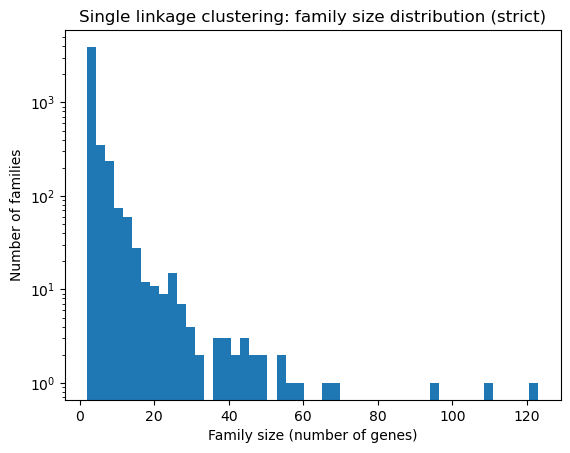

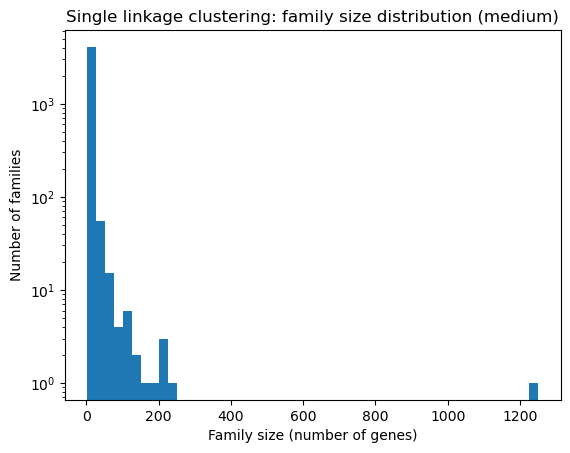

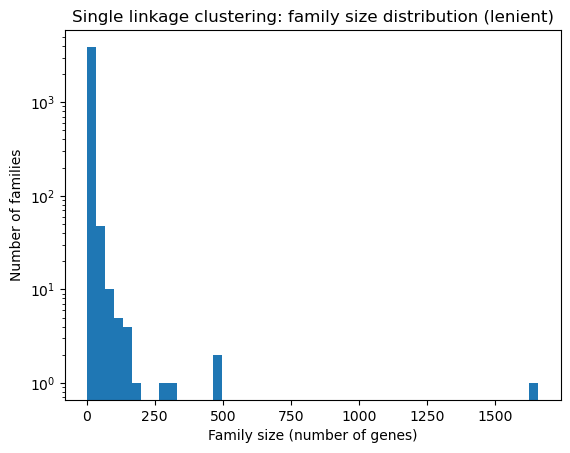

In [14]:
for name, fam_df in family_tables.items():
    plt.figure()
    plt.hist(fam_df["family_size"], bins=50)
    plt.title(f"Single linkage clustering: family size distribution ({name})")
    plt.xlabel("Family size (number of genes)")
    plt.ylabel("Number of families")
    plt.yscale("log")  # удобно, потому что много маленьких семейств
    plt.show()


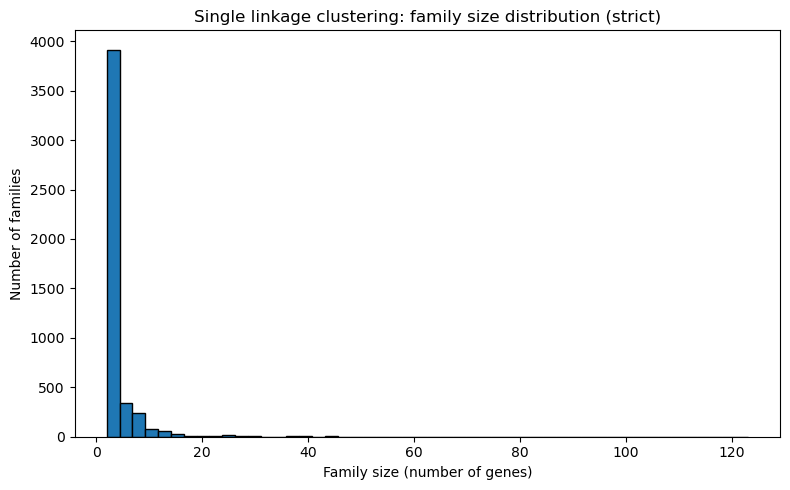

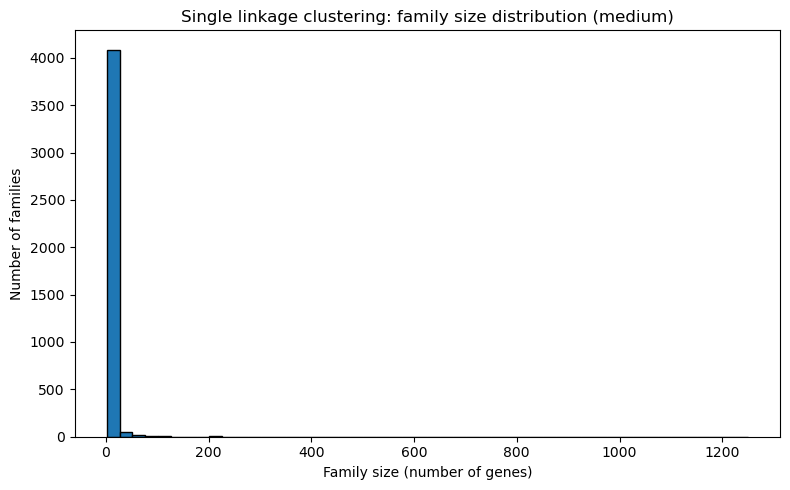

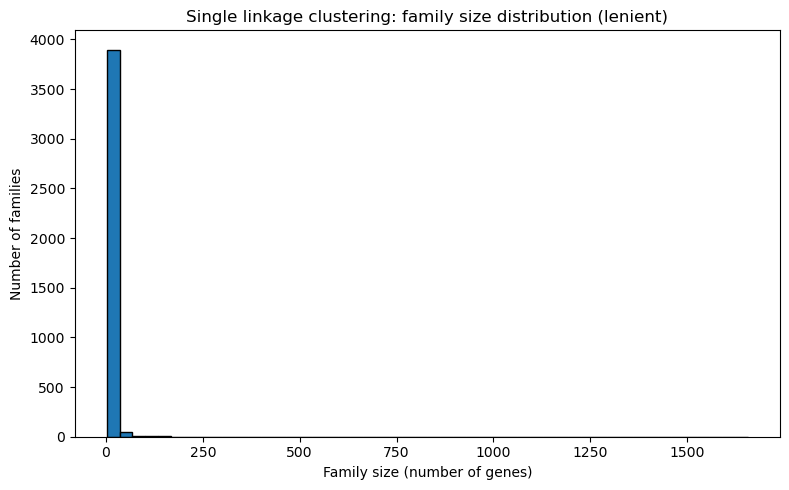

In [15]:
import matplotlib.pyplot as plt

for name, fam_df in family_tables.items():
    plt.figure(figsize=(8, 5))
    
    plt.hist(
        fam_df["family_size"],
        bins=50,
        edgecolor="black"
    )
    
    plt.title(f"Single linkage clustering: family size distribution ({name})")
    plt.xlabel("Family size (number of genes)")
    plt.ylabel("Number of families")
    
    plt.tight_layout()
    plt.show()
